In [1]:
# 第三方库
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from surprise import KNNBasic
from surprise import SVD
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
# 数据读取
data = pd.read_csv(r'E:\音乐推荐系统数据集\train_triplets.txt', sep='\t', header=None,
                   names=['user', 'song', 'play_count'], nrows=2000000)
data.head()

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user        object
 1   song        object
 2   play_count  int64 
dtypes: int64(1), object(2)
memory usage: 45.8+ MB


In [4]:
# 数据清洗
user_encoder = LabelEncoder()
data['user'] = user_encoder.fit_transform(data['user'].values)

song_encoder = LabelEncoder()
data['song'] = song_encoder.fit_transform(data['song'].values)

# 数据类型转换
data.astype({'user': 'int32', 'song': 'int32', 'play_count': 'int32'})

,user,song,play_count
0,29990,3209,1
1,29990,4702,1
2,29990,8475,2
3,29990,9707,1
4,29990,9717,1
...,...,...,...
1999995,14869,150910,2
1999996,14869,152803,1
1999997,14869,163072,2
1999998,14869,171650,1


In [5]:
user_playcounts = {}
for user, group in data.groupby('user'):
    user_playcounts[user] = group['play_count'].sum()

C:\Users\lelter\AppData\Local\Temp\ipykernel_1896\233467261.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(user_playcounts.values()), bins=5000, kde=False)


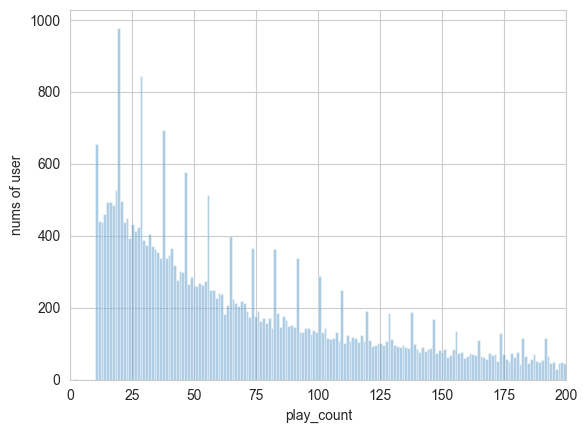

In [6]:
sns.distplot(list(user_playcounts.values()), bins=5000, kde=False)
plt.xlim(0, 200)
plt.xlabel('play_count')
plt.ylabel('nums of user')
plt.show()

In [7]:
temp_user = [user for user in user_playcounts.keys() if user_playcounts[user] > 100]
temp_playcounts = [playcounts for user, playcounts in user_playcounts.items() if playcounts > 100]

print('歌曲播放量大于100的用户数量占总体用户数量的比例为',
      str(round(len(temp_user) / len(user_playcounts), 4) * 100) + '%')
print('歌曲播放量大于100的用户产生的播放总量占总体播放总量的比例为',
      str(round(sum(temp_playcounts) / sum(user_playcounts.values()) * 100, 4)) + '%')
print('歌曲播放量大于100的用户产生的数据占总体数据的比例为',
      str(round(len(data[data.user.isin(temp_user)]) / len(data) * 100, 4)) + "%")

歌曲播放量大于100的用户数量占总体用户数量的比例为 39.51%
歌曲播放量大于100的用户产生的播放总量占总体播放总量的比例为 80.278%
歌曲播放量大于100的用户产生的数据占总体数据的比例为 71.26%


In [8]:
data = data[data.user.isin(temp_user)]  # 保留播放量大于100的用户

In [9]:
song_playcounts = {}  # 统计每首歌的播放量
for song, group in data.groupby('song'):
    song_playcounts[song] = group['play_count'].sum()

C:\Users\lelter\AppData\Local\Temp\ipykernel_1896\1793298616.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(song_playcounts.values()), bins=5000, kde=False)


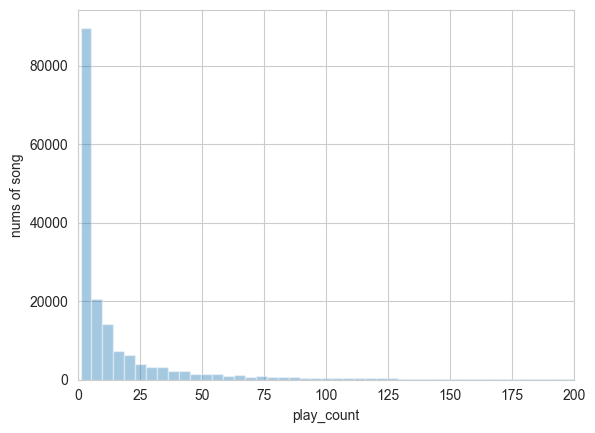

In [10]:
# 绘制歌曲播放量分布图
sns.distplot(list(song_playcounts.values()), bins=5000, kde=False)
plt.xlim(0, 200)
plt.xlabel('play_count')
plt.ylabel('nums of song')
plt.show()


In [11]:
temp_song = [song for song in song_playcounts.keys() if song_playcounts[song] > 50]
temp_playcounts = [playcounts for song, playcounts in song_playcounts.items() if playcounts > 50]
print('播放量大于50的歌曲数量占总体歌曲数量的比例为', str(round(len(temp_song) / len(song_playcounts), 4) * 100) + '%')
print('播放量大于50的歌曲产生的播放总量占总体播放总量的比例为',
      str(round(sum(temp_playcounts) / sum(song_playcounts.values()) * 100, 4)) + '%')
print('播放量大于50的歌曲产生的数据占总体数据的比例为',
      str(round(len(data[data.song.isin(temp_song)]) / len(data) * 100, 4)) + "%")


播放量大于50的歌曲数量占总体歌曲数量的比例为 10.2%
播放量大于50的歌曲产生的播放总量占总体播放总量的比例为 71.0557%
播放量大于50的歌曲产生的数据占总体数据的比例为 61.2672%


In [12]:
data = data[data.song.isin(temp_song)]  # 保留播放量大于50的歌曲

In [13]:
conn = sqlite3.connect(r'E:\音乐推荐系统数据集\track_metadata.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
cur.fetchall()
track_metadata_df = pd.read_sql("SELECT * from songs", conn)


In [14]:
track_metadata_df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,,Der Mystic,514.29832,0.000000,0.000000,0,2264873,-1,0


In [15]:
# 对于之前的歌曲编码，我们给一个字典，对歌曲和编码进行一一映射
song_labels = dict(zip(song_encoder.classes_, range(len(song_encoder.classes_))))

# 对于那些在之前没有出现过的歌曲，我们直接给一个最大的编码
encoder = lambda x: song_labels[x] if x in song_labels.keys() else len(song_labels)

# 对数据进行labelencoder
track_metadata_df['song_id'] = track_metadata_df['song_id'].apply(encoder)

In [16]:
track_metadata_df = track_metadata_df.rename(columns={'song_id': 'song'})

In [17]:
data = pd.merge(data, track_metadata_df, on='song')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907134 entries, 0 to 907133
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user                907134 non-null  int32  
 1   song                907134 non-null  int32  
 2   play_count          907134 non-null  int64  
 3   track_id            907134 non-null  object 
 4   title               907134 non-null  object 
 5   release             907134 non-null  object 
 6   artist_id           907134 non-null  object 
 7   artist_mbid         907134 non-null  object 
 8   artist_name         907134 non-null  object 
 9   duration            907134 non-null  float64
 10  artist_familiarity  907134 non-null  float64
 11  artist_hotttnesss   907134 non-null  float64
 12  year                907134 non-null  int64  
 13  track_7digitalid    907134 non-null  int64  
 14  shs_perf            907134 non-null  int64  
 15  shs_work            907134 non-nul

In [19]:
data = data.astype({'play_count': 'int32', 'duration': 'float32', 'artist_familiarity': 'float32',
                    'artist_hotttnesss': 'float32', 'year': 'int32', 'track_7digitalid': 'int32'})
print(' ')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907134 entries, 0 to 907133
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user                907134 non-null  int32  
 1   song                907134 non-null  int32  
 2   play_count          907134 non-null  int32  
 3   track_id            907134 non-null  object 
 4   title               907134 non-null  object 
 5   release             907134 non-null  object 
 6   artist_id           907134 non-null  object 
 7   artist_mbid         907134 non-null  object 
 8   artist_name         907134 non-null  object 
 9   duration            907134 non-null  float32
 10  artist_familiarity  907134 non-null  float32
 11  artist_hotttnesss   907134 non-null  float32
 12  year                907134 non-null  int32  
 13  track_7digitalid    907134 non-null  int32  
 14  shs_perf            907134 non-null  int64  
 15  shs_work            907134 non-nul

In [21]:
# 去重
data.drop_duplicates(inplace=True)
# 丢掉无用信息
data.drop(['track_id', 'artist_id', 'artist_mbid', 'duration', 'track_7digitalid', 'shs_perf', 'shs_work'], axis=1,
          inplace=True)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907134 entries, 0 to 907133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user                907134 non-null  int32  
 1   song                907134 non-null  int32  
 2   play_count          907134 non-null  int32  
 3   title               907134 non-null  object 
 4   release             907134 non-null  object 
 5   artist_name         907134 non-null  object 
 6   artist_familiarity  907134 non-null  float32
 7   artist_hotttnesss   907134 non-null  float32
 8   year                907134 non-null  int32  
dtypes: float32(2), int32(4), object(3)
memory usage: 48.4+ MB


In [23]:
data.head()

,user,song,play_count,title,release,artist_name,artist_familiarity,artist_hotttnesss,year
0,29990,3209,1,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
1,20160,3209,1,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
2,19083,3209,3,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
3,5860,3209,1,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
4,10262,3209,6,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0


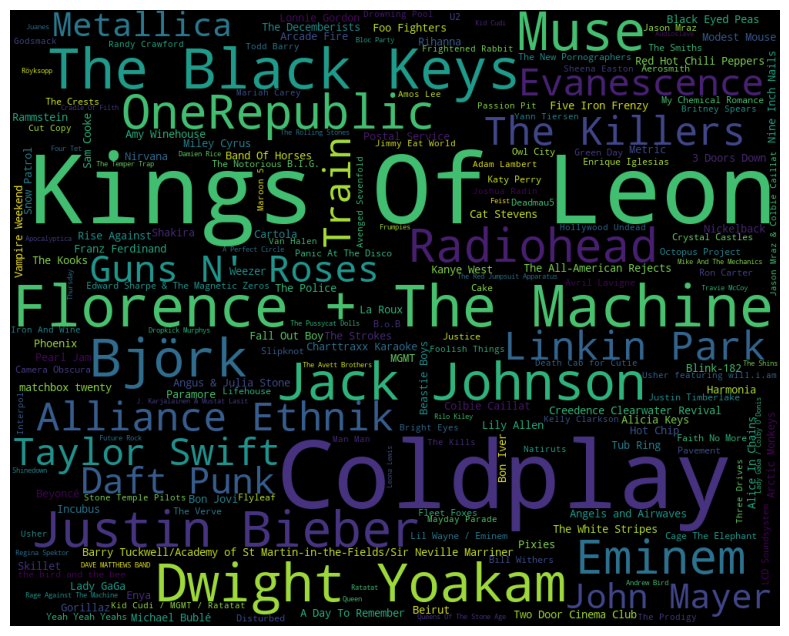

In [24]:
# 字典artist_playcounts记录每个歌手获得的点击量
artist_playcounts = {}
for artist, group in data.groupby('artist_name'):
    artist_playcounts[artist] = group['play_count'].sum()

# 作图
plt.figure(figsize=(12, 8))
wc = WordCloud(width=1000, height=800)
wc.generate_from_frequencies(artist_playcounts)
plt.imshow(wc)
plt.axis('off')
plt.show()

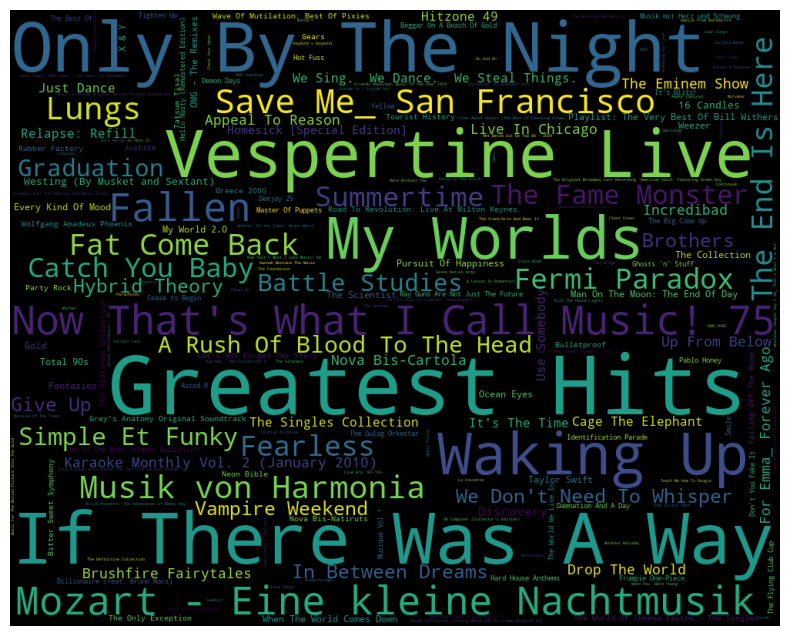

In [25]:
# 字典release_playcounts记录每个专辑获得的点击量
release_playcounts = {}
for release, group in data.groupby('release'):
    release_playcounts[release] = group['play_count'].sum()

# 作图
plt.figure(figsize=(12, 8))
wc = WordCloud(width=1000, height=800)
wc.generate_from_frequencies(release_playcounts)
plt.imshow(wc)
plt.axis('off')
plt.show()

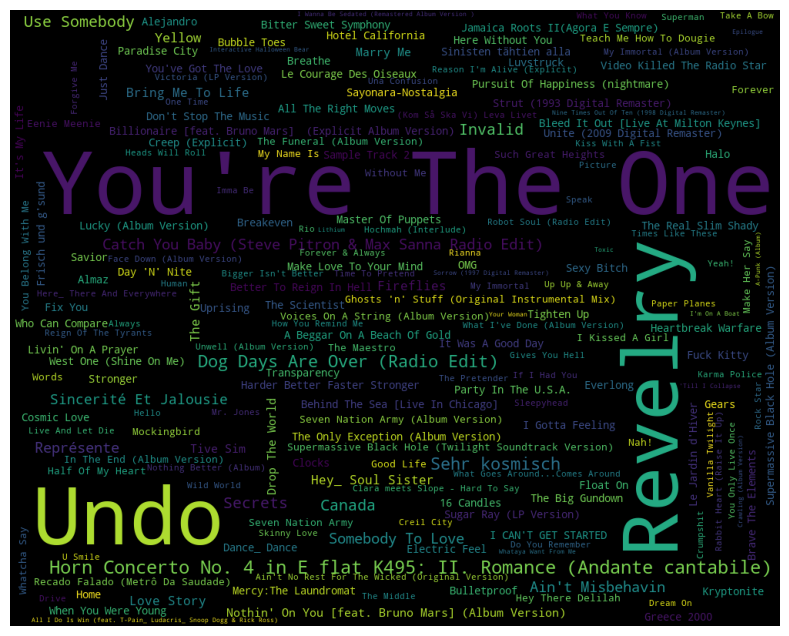

In [26]:
# 字典song_playcounts记录每首歌获得的点击量
song_playcounts = {}
for song, group in data.groupby('title'):
    song_playcounts[song] = group['play_count'].sum()

# 作图
plt.figure(figsize=(12, 8))
wc = WordCloud(width=1000, height=800)
wc.generate_from_frequencies(song_playcounts)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [27]:
# 基于排行榜的推荐
def recommendation_basedonPopularity(df, N=5):
    my_df = df.copy()
    # 字典song_peopleplay，记录每首歌听过的人数
    song_peopleplay = {}
    for song, group in my_df.groupby('title'):
        song_peopleplay[song] = group['user'].count()

    # 根据人数从大到小排序，并推荐前N首歌
    sorted_dict = sorted(song_peopleplay.items(), key=lambda x: x[1], reverse=True)[:N]
    # 取出歌曲
    return list(dict(sorted_dict).keys())


# 测试推荐结果
recommendation_basedonPopularity(data, N=5)

['Use Somebody',
 'Sehr kosmisch',
 'Dog Days Are Over (Radio Edit)',
 'Yellow',
 'Undo']

In [28]:
(data['play_count'].min(), data['play_count'].max())

(1, 1890)

In [29]:
data.head()

,user,song,play_count,title,release,artist_name,artist_familiarity,artist_hotttnesss,year
0,29990,3209,1,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
1,20160,3209,1,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
2,19083,3209,3,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
3,5860,3209,1,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
4,10262,3209,6,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0


In [30]:
# 基于协同过滤的推荐
user_averageScore = {}
for user, group in data.groupby('user'):
    user_averageScore[user] = group['play_count'].mean()  # 计算每个用户的平均点击量

In [31]:
user_averageScore

{8: 1.7185185185185186,
 9: 1.7058823529411764,
 10: 9.416666666666666,
 11: 1.8717948717948718,
 12: 1.2260869565217392,
 18: 5.409090909090909,
 19: 3.323529411764706,
 21: 2.1636363636363636,
 22: 2.212121212121212,
 25: 10.079545454545455,
 26: 1.126984126984127,
 27: 4.102941176470588,
 28: 2.0208333333333335,
 30: 2.7094017094017095,
 33: 4.095238095238095,
 35: 1.0303030303030303,
 38: 2.0,
 39: 1.5862068965517242,
 41: 1.951219512195122,
 42: 2.96,
 44: 8.0,
 46: 4.1,
 47: 2.4035087719298245,
 51: 2.210526315789474,
 57: 5.378378378378378,
 58: 3.3815789473684212,
 59: 1.890625,
 60: 3.7567567567567566,
 61: 3.1142857142857143,
 63: 1.8557692307692308,
 64: 2.3125,
 67: 19.990291262135923,
 69: 2.723684210526316,
 71: 3.3636363636363638,
 72: 7.113636363636363,
 73: 6.591836734693878,
 75: 1.5,
 78: 1.9950980392156863,
 79: 3.5569620253164556,
 81: 1.2777777777777777,
 82: 2.8048780487804876,
 83: 14.075471698113208,
 85: 4.645161290322581,
 88: 3.2169312169312168,
 90: 1.46391

In [32]:
data['rating'] = data.apply(lambda x: np.log(2 + x.play_count / user_averageScore[x.user]), axis=1)  # 计算每个用户对每首歌的评分

C:\Users\lelter\AppData\Local\Temp\ipykernel_1896\3582445437.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['rating'].values, bins=100)  # 评分分布


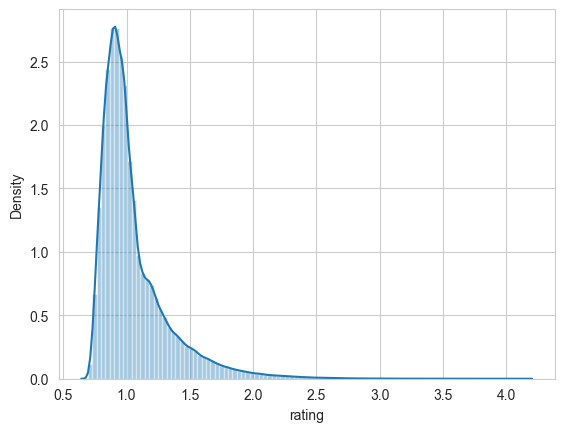

In [33]:
sns.distplot(data['rating'].values, bins=100)  # 评分分布
plt.xlabel('rating')
plt.show()

In [34]:
# 得到用户-音乐评分矩阵
user_item_rating = data[['user', 'song', 'rating']]
user_item_rating = user_item_rating.rename(columns={'song': 'item'})
user_item_rating

,user,item,rating
0,29990,3209,0.969401
1,20160,3209,0.937644
2,19083,3209,1.018099
3,5860,3209,0.871477
4,10262,3209,1.188672
...,...,...,...
907129,19890,172934,2.596228
907130,13331,129720,2.068112
907131,26899,89927,1.877162
907132,19366,74450,1.886947


In [35]:
#itemCF

# 阅读器
reader = Reader(line_format='user item rating', sep=',')
# 载入数据
raw_data = Dataset.load_from_df(user_item_rating, reader=reader)
# 分割数据集
kf = KFold(n_splits=5)
# 构建模型
knn_itemcf = KNNBasic(k=40, sim_options={'user_based': False})
# 训练数据集，并返回rmse误差
for trainset, testset in kf.split(raw_data):
    knn_itemcf.fit(trainset)
    predictions = knn_itemcf.test(testset)
    accuracy.rmse(predictions, verbose=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2764
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2771
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2756
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2763
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2755


In [36]:
#用户听过的歌曲集合
user_songs = {}
for user, group in user_item_rating.groupby('user'):
    user_songs[user] = group['item'].values.tolist()

# 歌曲集合
songs = user_item_rating['item'].unique().tolist()

# 歌曲id和歌曲名称对应关系
songID_titles = {}
for index in data.index:
    songID_titles[data.loc[index, 'song']] = data.loc[index, 'title']
songs

[3209,
 4702,
 8475,
 13918,
 15307,
 15622,
 20279,
 24070,
 25109,
 31309,
 31969,
 41656,
 42079,
 45330,
 50614,
 60749,
 70832,
 70915,
 75093,
 75582,
 83826,
 84849,
 89687,
 95821,
 97279,
 99329,
 101424,
 106626,
 107581,
 111866,
 117113,
 123273,
 126033,
 126199,
 126667,
 134894,
 135125,
 136178,
 136826,
 137528,
 144469,
 146334,
 148203,
 149884,
 155122,
 161211,
 163551,
 165841,
 170728,
 171316,
 176520,
 177975,
 179994,
 181978,
 190566,
 1759,
 3470,
 5682,
 6027,
 9070,
 9089,
 9199,
 9689,
 10693,
 10925,
 16682,
 24225,
 27681,
 39090,
 43933,
 46653,
 53787,
 56381,
 56767,
 63400,
 64588,
 66282,
 67114,
 75112,
 81303,
 81646,
 83171,
 83590,
 89251,
 91400,
 93171,
 95968,
 97976,
 104031,
 104376,
 106020,
 106790,
 108917,
 109436,
 114067,
 119428,
 127720,
 129979,
 140450,
 141891,
 143000,
 147090,
 147233,
 147640,
 150207,
 152557,
 153780,
 153803,
 162188,
 162254,
 162448,
 163252,
 163949,
 167293,
 171857,
 174765,
 175004,
 178033,
 185046,

In [37]:
songID_titles

{3209: 'The Cove',
 4702: 'Nothing from Nothing',
 8475: 'Entre Dos Aguas',
 13918: '12 segundos de oscuridad',
 15307: 'Stronger',
 15622: 'Constellations',
 20279: "You're My Flame [Album Version]",
 24070: 'Learn To Fly',
 25109: "Apuesta Por El Rock 'N' Roll",
 31309: 'Paper Gangsta',
 31969: "You Don't Have To Believe Me (Album Version)",
 41656: 'Winter In The Hamptons',
 42079: 'Stacked Actors',
 45330: 'Sehr kosmisch',
 50614: 'My Love Has Gone',
 60749: "Heaven's gonna burn your eyes",
 70832: 'Let It Be Sung',
 70915: "I'll Be Missing You (Featuring Faith Evans & 112)(Album Version)",
 75093: 'Love Shack',
 75582: 'Clarity',
 83826: "I?'m A Steady Rollin? Man",
 84849: 'Nice To Fit In',
 89687: 'The Old Saloon',
 95821: 'Behind The Sea [Live In Chicago]',
 97279: 'Champion',
 99329: 'Breakout',
 101424: 'Do You Wanna Dance',
 106626: 'Ragged Wood',
 107581: 'Llueve',
 111866: 'Mykonos',
 117113: 'Country Road',
 123273: 'The Pageant Of The Bizarre [Album Version]',
 126033: '

In [38]:
user_songs

{8: [75093,
  126199,
  16149,
  146426,
  28857,
  68044,
  101406,
  155773,
  43509,
  127733,
  11678,
  160884,
  98821,
  90863,
  135379,
  137445,
  107883,
  107883,
  53312,
  103152,
  143132,
  123398,
  176924,
  9682,
  173689,
  133236,
  81346,
  13668,
  147777,
  147777,
  132758,
  65800,
  37822,
  163570,
  76577,
  143266,
  160882,
  82396,
  39231,
  10862,
  158796,
  98776,
  123112,
  193381,
  159255,
  79910,
  183921,
  89286,
  117610,
  172219,
  74199,
  81451,
  95835,
  186685,
  12755,
  89960,
  145353,
  102505,
  129157,
  131622,
  22246,
  98993,
  115346,
  119365,
  33545,
  158441,
  101075,
  136692,
  130169,
  71297,
  25579,
  51566,
  184298,
  81560,
  174632,
  14139,
  96936,
  5210,
  74287,
  108450,
  104772,
  80938,
  50430,
  490,
  7641,
  9158,
  11058,
  13763,
  17515,
  19216,
  21887,
  26677,
  37661,
  39784,
  40076,
  43717,
  43762,
  44254,
  56550,
  67057,
  76598,
  76676,
  88551,
  94622,
  100868,
  107112,
  1

In [39]:
user_item_rating.head()


,user,item,rating
0,29990,3209,0.969401
1,20160,3209,0.937644
2,19083,3209,1.018099
3,5860,3209,0.871477
4,10262,3209,1.188672


In [40]:
# itemCF 推荐
def recommendation_basedonItemCF(userID, N=5):
    # 用户听过的音乐列表
    used_items = user_songs[userID]
    print('用户听过的歌曲：')
    for item in used_items:
        print(songID_titles[item])
    # 用户对未听过音乐的评分
    item_ratings = {}
    for item in songs:
        if item not in used_items:
            item_ratings[item] = knn_itemcf.predict(userID, item).est

    # 找出评分靠前的5首歌曲
    song_ids = dict(sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:N])
    song_topN = [songID_titles[s] for s in song_ids.keys()]

    return song_topN

recommendation_basedonItemCF(29990)

用户听过的歌曲：
The Cove
Nothing from Nothing
Entre Dos Aguas
12 segundos de oscuridad
Stronger
Stronger
Constellations
You're My Flame [Album Version]
Learn To Fly
Apuesta Por El Rock 'N' Roll
Paper Gangsta
You Don't Have To Believe Me (Album Version)
Winter In The Hamptons
Stacked Actors
Sehr kosmisch
My Love Has Gone
Heaven's gonna burn your eyes
Let It Be Sung
I'll Be Missing You (Featuring Faith Evans & 112)(Album Version)
Love Shack
Clarity
I?'m A Steady Rollin? Man
Nice To Fit In
The Old Saloon
Behind The Sea [Live In Chicago]
Champion
Breakout
Do You Wanna Dance
Ragged Wood
Llueve
Mykonos
Country Road
The Pageant Of The Bizarre [Album Version]
Oh No
Love Song For No One
Jewels And Gold
Warning
83
Neon
The Middle
High and dry
All That We Perceive
The Christmas Song  (LP Version)
Our Swords (Soundtrack Version)
Are You In?
Drive
Generator
Come Back To Bed
He Doesn't Know Why
Trani
Bigger Isn't Better
Sun Giant
City Love
Right Back
Moonshine
Holes To Heaven


['Murano',
 'Divine Comedy',
 'Fugue (A Revelation)',
 'The Highest Journey',
 'Coppershot']

In [41]:
# userCF

# 阅读器
reader = Reader(line_format='user item rating', sep=',')
# 载入数据
raw_data = Dataset.load_from_df(user_item_rating, reader=reader)
# 分割数据集
kf = KFold(n_splits=5)
# 构建模型
knn_usercf = KNNBasic(k=40, sim_options={'user_based': True})
# 训练数据集，并返回rmse误差
for trainset, testset in kf.split(raw_data):
    knn_usercf.fit(trainset)
    predictions = knn_usercf.test(testset)
    accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2726
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2723
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2735
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2709
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2735


In [42]:
# userCF 推荐
def recommendation_basedonUserCF(userID, N=5):
    # 用户听过的音乐列表
    used_items = user_songs[userID]

    # 用户对未听过音乐的评分
    item_ratings = {}
    for item in songs:
        if item not in used_items:
            item_ratings[item] = knn_usercf.predict(userID, item).est

    # 找出评分靠前的5首歌曲
    song_ids = dict(sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:N])
    song_topN = [songID_titles[s] for s in song_ids.keys()]

    return song_topN

recommendation_basedonUserCF(29990)

['Point Of No Return (1995 Digital Remaster)',
 'Imaginary Music (Album Version)',
 'Sitting on Top of the World',
 'Thais II',
 'Revizor']

In [43]:
# 复制原data数据
rank_data = data.copy()
# 去掉无用的title列
rank_data.drop('title', axis=1, inplace=True)

# 将object类型数据用labelencoder编码
release_encoder = LabelEncoder()
rank_data['release'] = release_encoder.fit_transform(rank_data['release'].values)

artist_name_encoder = LabelEncoder()
rank_data['artist_name'] = artist_name_encoder.fit_transform(rank_data['artist_name'].values)

# 根据rating的取值，更新rating值
rank_data['rating'] = rank_data['rating'].apply(lambda x: 0 if x < 0.7 else 1)

rank_data.head()

,user,song,play_count,release,artist_name,artist_familiarity,artist_hotttnesss,year,rating
0,29990,3209,1,8740,2556,0.832012,0.677482,0,1
1,20160,3209,1,8740,2556,0.832012,0.677482,0,1
2,19083,3209,3,8740,2556,0.832012,0.677482,0,1
3,5860,3209,1,8740,2556,0.832012,0.677482,0,1
4,10262,3209,6,8740,2556,0.832012,0.677482,0,1


In [44]:
# 取出20%的数据作为数据集
small_data = rank_data.sample(frac=0.2)
# 将数据集分成gbdt训练街和lr训练集
X_gbdt, X_lr, y_gbdt, y_lr = train_test_split(small_data.iloc[:, :-1].values, small_data.iloc[:, -1].values, test_size=0.5)

In [45]:
y_gbdt

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [46]:
depth = 3
n_estimator = 50

print('当前n_estimators=', n_estimator)
# 训练gbdt
gbdt = GradientBoostingClassifier(n_estimators=n_estimator, max_depth=depth, min_samples_split=3, min_samples_leaf=2)
gbdt.fit(X_gbdt, y_gbdt)

print('当前gbdt训练完成！')

# one-hot编码
onehot = OneHotEncoder()
onehot.fit(gbdt.apply(X_gbdt).reshape(-1, n_estimator))

# 对gbdt结果进行one-hot编码，然后训练lr
lr = LogisticRegression()
lr.fit(onehot.transform(gbdt.apply(X_lr).reshape(-1, n_estimator)), y_lr)

print('当前lr训练完成！')

# 用auc作为指标
lr_pred = lr.predict(onehot.transform(gbdt.apply(X_lr).reshape(-1, n_estimator)))
auc_score = roc_auc_score(y_lr, lr_pred)

print('当前n_estimators和auc分别为', n_estimator, auc_score)
print('#'*40)

当前n_estimators= 50
当前gbdt训练完成！
当前lr训练完成！
当前n_estimators和auc分别为 50 0.5
########################################
